# Obrada prirodnog jezika za razumijevanje povratnih informacija klijenata u ugostiteljskoj industriji

## Potrebni moduli

In [1]:
import re
import os
from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk import tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Učitavanje podataka

In [3]:
# Za prikazivanje cijelih komentara postaviti na 0
pd.set_option("max_colwidth", 100)

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/dsabljic/UUI-NLP-u-ugostiteljstvu/master/data/tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


## EDA

In [4]:
# Vrijednosti koje nedostaju
df.isna().sum()

Review    0
Rating    0
dtype: int64

In [5]:
df.Rating.describe()

count    20491.000000
mean         3.952223
std          1.233030
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: Rating, dtype: float64

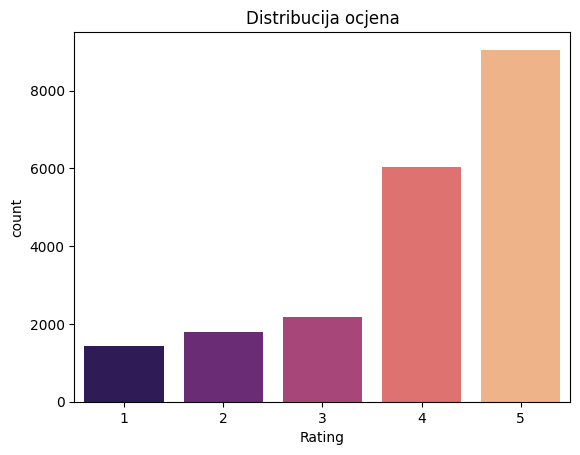

In [6]:
# Distribucija ocjena
sns.countplot(data=df, x="Rating", palette="magma").set_title("Distribucija ocjena");

In [7]:
# Duljina review-a (char)
df['Length'] = df['Review'].str.len()
df.head()

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,4,593
1,ok nothing special charge diamond member hilto...,2,1689
2,nice rooms not 4* experience hotel monaco seat...,3,1427
3,"unique, great stay, wonderful time hotel monac...",5,600
4,"great stay great stay, went seahawk game aweso...",5,1281


In [8]:
# Duljina review-a (riječ)
def word_count(review):
    review_list = review.split()
    return len(review_list)

df['Word count'] = df['Review'].apply(word_count)
df.head()

,Review,Rating,Length,Word count
0,nice hotel expensive parking got good deal sta...,4,593,87
1,ok nothing special charge diamond member hilto...,2,1689,250
2,nice rooms not 4* experience hotel monaco seat...,3,1427,217
3,"unique, great stay, wonderful time hotel monac...",5,600,89
4,"great stay great stay, went seahawk game aweso...",5,1281,191


In [9]:
# Deskriptivna statistika
df.Length.describe()

count    20491.000000
mean       724.896833
std        689.101024
min         44.000000
25%        339.000000
50%        537.000000
75%        859.000000
max      13501.000000
Name: Length, dtype: float64

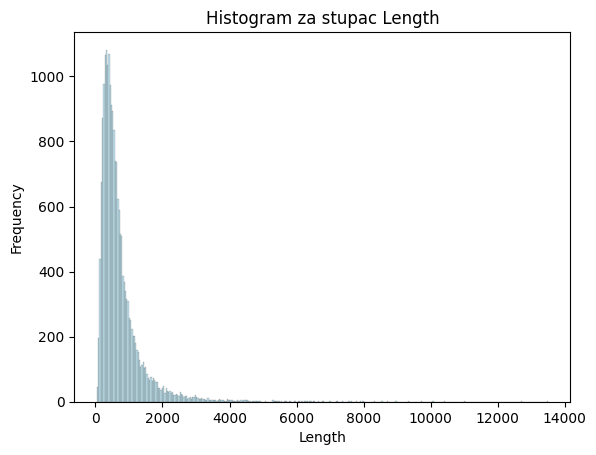

In [19]:
sns.histplot(df['Length'], kde=False, color='lightblue')
plt.title('Histogram za stupac Length')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

In [11]:
df['Word count'].describe()

count    20491.000000
mean       104.375824
std        100.656586
min          7.000000
25%         48.000000
50%         77.000000
75%        124.000000
max       1931.000000
Name: Word count, dtype: float64

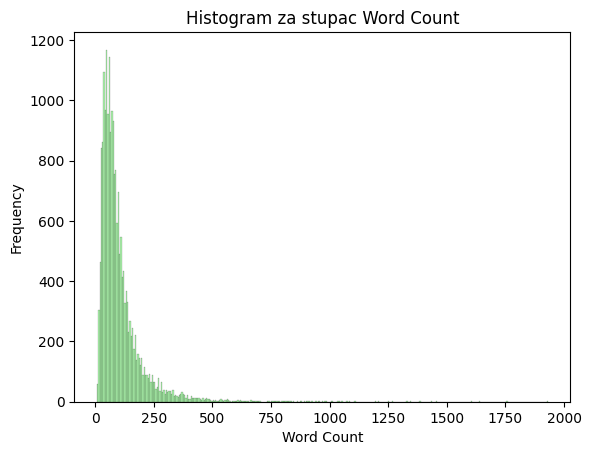

In [15]:
sns.histplot(df['Word count'], kde=False, color='lightgreen')
plt.title('Histogram za stupac Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

## Najzastupljenije riječi i *n*-grami

In [14]:
df.drop(['Length', 'Word count'], axis = 1, inplace = True)
df.head()

,Review,Rating
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took adv...",4
1,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, sta...",2
2,nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathro...,3
3,"unique, great stay, wonderful time hotel monaco, location excellent short stroll main downtown s...",5
4,"great stay great stay, went seahawk game awesome, downfall view building did n't complain, room ...",5


In [15]:
def clean(review):

    review = review.lower()
    review = re.sub('[^a-z A-Z 0-9-]+', '', review) # uklanjanje specijalnih znakova
    review = " ".join([word for word in review.split() if word not in stopwords.words('english')])

    return review

In [16]:
df['Review'] = df['Review'].apply(clean)

In [17]:
def split_into_words(text):
    text_list = text.split()
    return text_list

df['Review_lists'] = df['Review'].apply(split_into_words)

In [18]:
df.head()

,Review,Rating,Review_lists
0,nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advi...,4,"[nice, hotel, expensive, parking, got, good, deal, stay, hotel, anniversary, arrived, late, even..."
1,ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle star...,2,"[ok, nothing, special, charge, diamond, member, hilton, decided, chain, shot, 20th, anniversary,..."
2,nice rooms 4 experience hotel monaco seattle good hotel nt 4 levelpositives large bathroom medit...,3,"[nice, rooms, 4, experience, hotel, monaco, seattle, good, hotel, nt, 4, levelpositives, large, ..."
3,unique great stay wonderful time hotel monaco location excellent short stroll main downtown shop...,5,"[unique, great, stay, wonderful, time, hotel, monaco, location, excellent, short, stroll, main, ..."
4,great stay great stay went seahawk game awesome downfall view building nt complain room huge sta...,5,"[great, stay, great, stay, went, seahawk, game, awesome, downfall, view, building, nt, complain,..."


In [19]:
corpus = [word for review_list in df['Review_lists'] for word in review_list]
len(corpus)

2060911

In [20]:
most_common_words = Counter(corpus).most_common(10)
most_common_words

[('hotel', 48844),
 ('room', 34279),
 ('great', 21068),
 ('nt', 18989),
 ('good', 16953),
 ('staff', 16193),
 ('stay', 15142),
 ('nice', 12393),
 ('rooms', 12005),
 ('location', 11009)]

In [23]:
words, freq = zip(*most_common_words)

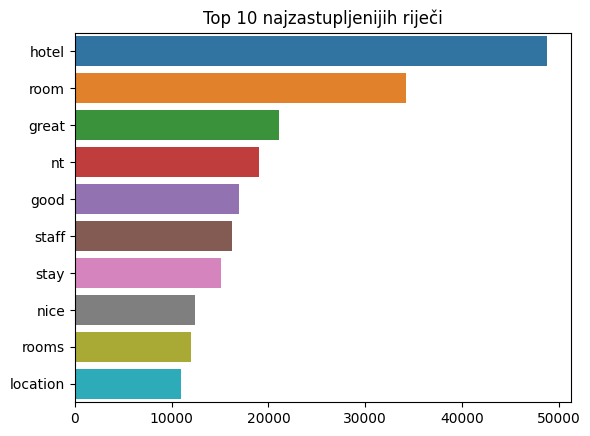

In [27]:
sns.barplot(x=list(freq), y=list(words))
plt.title('Top 10 najzastupljenijih riječi')
plt.show()

In [32]:
def display_ngram(n, df):
  cv = CountVectorizer(ngram_range=(n,n))
  n_gram = cv.fit_transform(df['Review'])
  count_values = n_gram.toarray().sum(axis=0)
  ngram_df = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
  ngram_df.columns = ["frequency", "ngram"]

  sns.barplot(x=ngram_df['frequency'][:10], y=ngram_df['ngram'][:10])
  plt.title('Top 10 najzastupljenijih n-grama')
  plt.show()

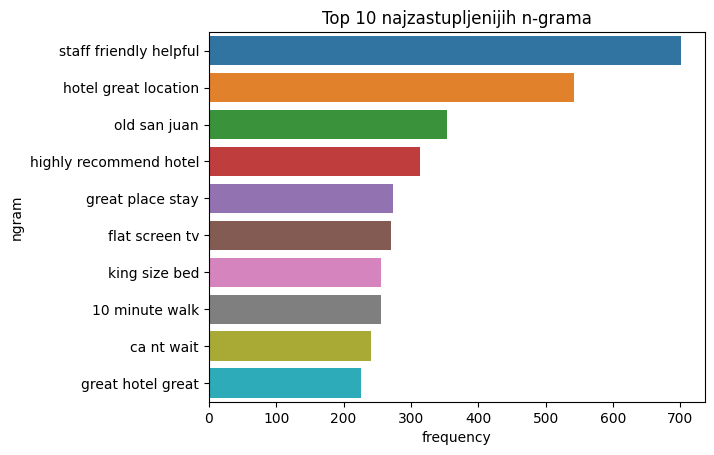

In [33]:
n_gram = display_ngram(3, df)

## Analiza sentimenta sa sekvencijalnim modelima

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, LSTM, Bidirectional, Dense, Dropout, TextVectorization
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from nltk.stem.snowball import SnowballStemmer

In [41]:
df = pd.read_csv('https://raw.githubusercontent.com/dsabljic/UUI-NLP-u-ugostiteljstvu/master/data/tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [42]:
df['Label'] = df['Rating'].apply(lambda x: 0 if x in [1, 2] else (1 if x == 3 else 2)) # 0 - negativna recenzija, 1 - neutralna, 2 - pozitivna

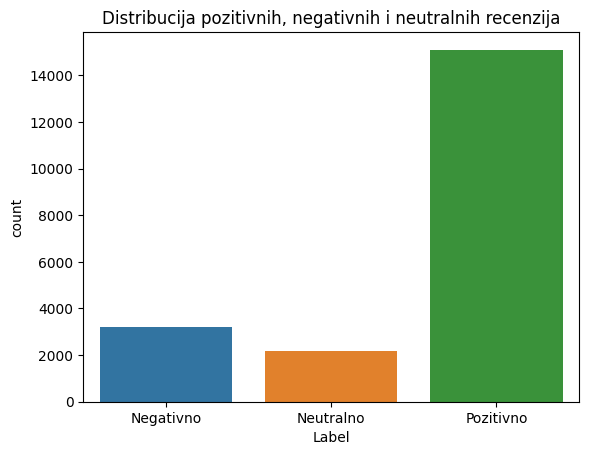

In [43]:
sns.countplot(x='Label', data=df)
plt.title('Distribucija pozitivnih, negativnih i neutralnih recenzija')
plt.xticks(ticks=[0, 1, 2], labels=['Negativno', 'Neutralno', 'Pozitivno']);

In [44]:
X_train, X_test, y_train, y_test = train_test_split(df["Review"], df["Label"], test_size=0.2, random_state=72)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=72)

In [45]:
stop_words = set(stopwords.words('english'))
words_to_keep = {'not', 'no', 'nt', 'very'}
filtered_stop_words = stop_words - words_to_keep

stemmer = SnowballStemmer("english")

def custom_preprocessing_sw_removal(text):
    # Provjera je li tekst string i pretvaranje u string ako nije
    if not isinstance(text, str):
        text = str(text)

    # Pretvaranje teksta u mala slova
    text = text.lower()
    # Uklanjanje interpunkcije
    text = re.sub(r'[^\w\s]', '', text)
    # Stemming i uklanjanje stopwordsa osim onih koji utječu na sentiment
    text = " ".join(stemmer.stem(word) for word in text.split() if word not in filtered_stop_words)

    return text

In [46]:
X_train = X_train.apply(custom_preprocessing_sw_removal)
X_val = X_val.apply(custom_preprocessing_sw_removal)
X_test = X_test.apply(custom_preprocessing_sw_removal)

In [47]:
batch_size = 32
VOCAB_TOKENS = 5000

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_TOKENS)

encoder.adapt(train_ds.map(lambda text, labels: text))

np.array(encoder.get_vocabulary())[:20]

array(['', '[UNK]', 'hotel', 'room', 'not', 'stay', 'great', 'nt', 'good',
       'staff', 'night', 'locat', 'nice', 'day', 'time', 'no', 'servic',
       'clean', 'walk', 'restaur'], dtype='<U14')

In [48]:
def plot_metrics(history):
    metrics = pd.DataFrame(history.history)
    metrics[['accuracy', 'val_accuracy']].plot()
    metrics[['loss', 'val_loss']].plot()

### *Vanilla* RNN

Epoch 1/10
385/385 [==============================] - 279s 720ms/step - loss: 0.8188 - accuracy: 0.7039 - val_loss: 0.6270 - val_accuracy: 0.7882
Epoch 2/10
385/385 [==============================] - 259s 675ms/step - loss: 0.5488 - accuracy: 0.8182 - val_loss: 0.4800 - val_accuracy: 0.8277
Epoch 3/10
385/385 [==============================] - 258s 670ms/step - loss: 0.4534 - accuracy: 0.8463 - val_loss: 0.4625 - val_accuracy: 0.8331
Epoch 4/10
385/385 [==============================] - 259s 672ms/step - loss: 0.3842 - accuracy: 0.8617 - val_loss: 0.4577 - val_accuracy: 0.8275
Epoch 5/10
385/385 [==============================] - 256s 665ms/step - loss: 0.4105 - accuracy: 0.8430 - val_loss: 0.5265 - val_accuracy: 0.8099
Epoch 6/10
385/385 [==============================] - 258s 672ms/step - loss: 0.3019 - accuracy: 0.8806 - val_loss: 0.5082 - val_accuracy: 0.8363
Epoch 7/10
385/385 [==============================] - 257s 670ms/step - loss: 0.2437 - accuracy: 0.9011 - val_loss: 0.5782 -

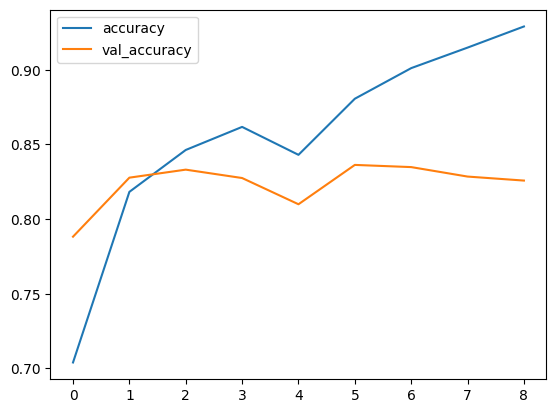

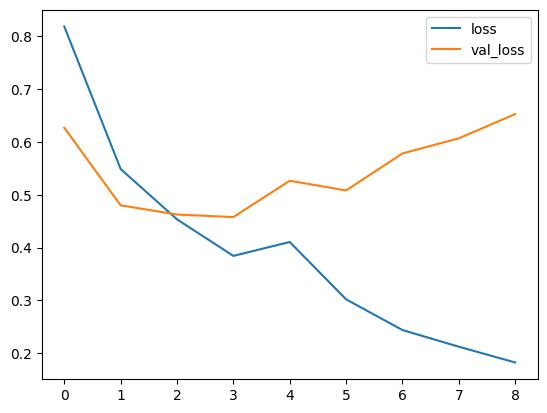

In [49]:
rnn_model = Sequential([
    encoder,
    Embedding(len(encoder.get_vocabulary()), 50, mask_zero = True),
    SimpleRNN(32),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')])

rnn_model.compile(optimizer=Adam(learning_rate=3e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = rnn_model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

In [50]:
test_loss, test_acc = rnn_model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 8s 66ms/step - loss: 0.6281 - accuracy: 0.8283
Test Loss: 0.628058135509491
Test Accuracy: 0.8282507658004761


### GRU

Epoch 1/10
385/385 [==============================] - 42s 99ms/step - loss: 0.9539 - accuracy: 0.7494 - val_loss: 0.5506 - val_accuracy: 0.8231
Epoch 2/10
385/385 [==============================] - 21s 56ms/step - loss: 0.5360 - accuracy: 0.8337 - val_loss: 0.5118 - val_accuracy: 0.8326
Epoch 3/10
385/385 [==============================] - 16s 41ms/step - loss: 0.4777 - accuracy: 0.8480 - val_loss: 0.4822 - val_accuracy: 0.8404
Epoch 4/10
385/385 [==============================] - 15s 38ms/step - loss: 0.4390 - accuracy: 0.8570 - val_loss: 0.4953 - val_accuracy: 0.8216
Epoch 5/10
385/385 [==============================] - 13s 35ms/step - loss: 0.4092 - accuracy: 0.8621 - val_loss: 0.5100 - val_accuracy: 0.8421
Epoch 6/10
385/385 [==============================] - 11s 30ms/step - loss: 0.3856 - accuracy: 0.8703 - val_loss: 0.5294 - val_accuracy: 0.8419
Epoch 7/10
385/385 [==============================] - 12s 30ms/step - loss: 0.5134 - accuracy: 0.8184 - val_loss: 0.6650 - val_accuracy:

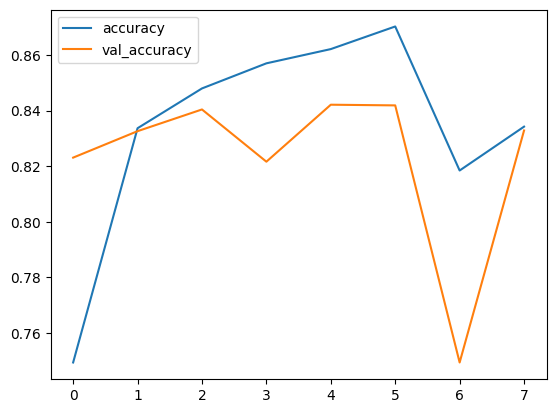

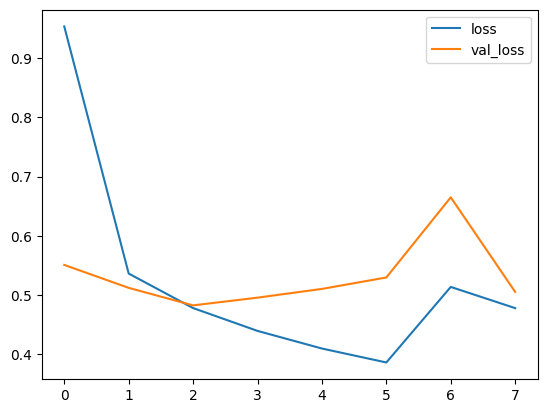

In [58]:
gru_model = Sequential([
    encoder,
    Embedding(len(encoder.get_vocabulary()), 50, mask_zero = True),
    GRU(32),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005)),
    Dropout(0.5),
    Dense(3, activation='softmax')])

gru_model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = gru_model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

In [59]:
test_loss, test_acc = gru_model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 1s 10ms/step - loss: 0.5069 - accuracy: 0.8258
Test Loss: 0.5068988800048828
Test Accuracy: 0.8258111476898193


### Dvosmjerna GRU mreža

Epoch 1/10
385/385 [==============================] - 54s 116ms/step - loss: 0.9219 - accuracy: 0.7927 - val_loss: 0.4906 - val_accuracy: 0.8450
Epoch 2/10
385/385 [==============================] - 28s 74ms/step - loss: 0.4533 - accuracy: 0.8590 - val_loss: 0.4617 - val_accuracy: 0.8407
Epoch 3/10
385/385 [==============================] - 22s 57ms/step - loss: 0.3848 - accuracy: 0.8755 - val_loss: 0.4376 - val_accuracy: 0.8551
Epoch 4/10
385/385 [==============================] - 19s 50ms/step - loss: 0.3469 - accuracy: 0.8883 - val_loss: 0.4512 - val_accuracy: 0.8516
Epoch 5/10
385/385 [==============================] - 19s 50ms/step - loss: 0.3153 - accuracy: 0.9041 - val_loss: 0.4857 - val_accuracy: 0.8446
Epoch 6/10
385/385 [==============================] - 18s 46ms/step - loss: 0.2933 - accuracy: 0.9126 - val_loss: 0.5017 - val_accuracy: 0.8450

Final val_accuracy: 84.50%



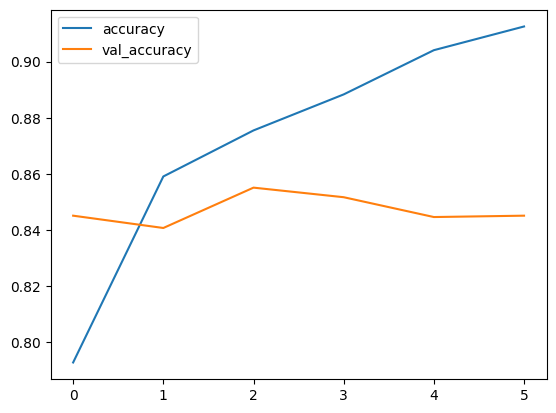

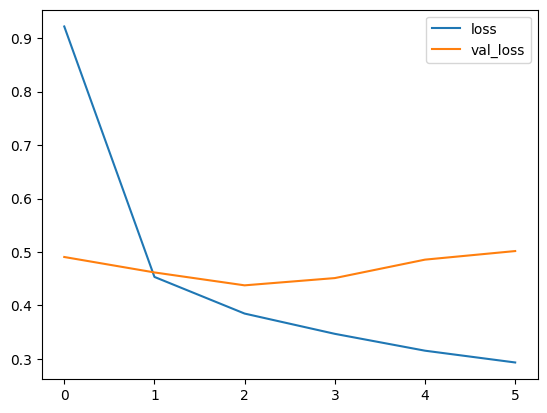

In [60]:
bi_gru_model = tf.keras.models.Sequential([
    encoder,
    Embedding(len(encoder.get_vocabulary()), 50, mask_zero = True),
    Bidirectional(GRU(32)),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005)),
    Dropout(0.4),
    Dense(3, activation='softmax')])

bi_gru_model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = bi_gru_model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

In [61]:
test_loss, test_acc = bi_gru_model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 2s 15ms/step - loss: 0.5237 - accuracy: 0.8322
Test Loss: 0.5236930251121521
Test Accuracy: 0.8321541547775269


### LSTM

Epoch 1/10
385/385 [==============================] - 42s 99ms/step - loss: 1.0461 - accuracy: 0.7734 - val_loss: 0.6143 - val_accuracy: 0.8292
Epoch 2/10
385/385 [==============================] - 23s 60ms/step - loss: 0.5782 - accuracy: 0.8264 - val_loss: 0.5166 - val_accuracy: 0.8353
Epoch 3/10
385/385 [==============================] - 17s 43ms/step - loss: 0.4871 - accuracy: 0.8511 - val_loss: 0.4853 - val_accuracy: 0.8328
Epoch 4/10
385/385 [==============================] - 16s 41ms/step - loss: 0.4533 - accuracy: 0.8608 - val_loss: 0.4833 - val_accuracy: 0.8419
Epoch 5/10
385/385 [==============================] - 11s 29ms/step - loss: 0.4070 - accuracy: 0.8694 - val_loss: 0.4637 - val_accuracy: 0.8436
Epoch 6/10
385/385 [==============================] - 11s 30ms/step - loss: 0.3905 - accuracy: 0.8724 - val_loss: 0.4751 - val_accuracy: 0.8470
Epoch 7/10
385/385 [==============================] - 11s 29ms/step - loss: 0.3636 - accuracy: 0.8819 - val_loss: 0.4681 - val_accuracy:

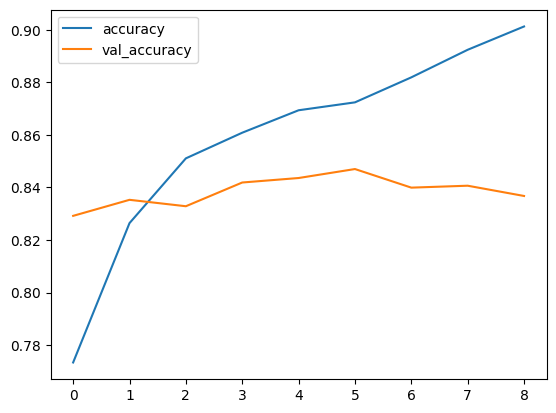

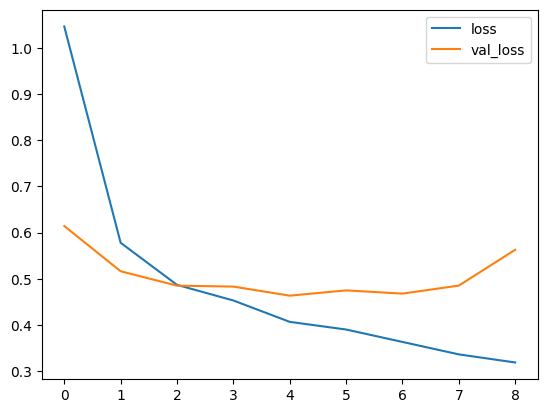

In [62]:
lstm_model = tf.keras.models.Sequential([
    encoder,
    Embedding(len(encoder.get_vocabulary()), 50, mask_zero = True),
    LSTM(64),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005)),
    Dropout(0.5),
    Dense(3, activation='softmax')])

lstm_model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = lstm_model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

In [63]:
test_loss, test_acc = lstm_model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 1s 10ms/step - loss: 0.5731 - accuracy: 0.8256
Test Loss: 0.5730782151222229
Test Accuracy: 0.8255671858787537


### Dvosmjerni LSTM

Epoch 1/20
385/385 [==============================] - 52s 112ms/step - loss: 1.0123 - accuracy: 0.7977 - val_loss: 0.4838 - val_accuracy: 0.8504
Epoch 2/20
385/385 [==============================] - 28s 72ms/step - loss: 0.4757 - accuracy: 0.8564 - val_loss: 0.4439 - val_accuracy: 0.8563
Epoch 3/20
385/385 [==============================] - 24s 61ms/step - loss: 0.4129 - accuracy: 0.8686 - val_loss: 0.4381 - val_accuracy: 0.8565
Epoch 4/20
385/385 [==============================] - 20s 51ms/step - loss: 0.3862 - accuracy: 0.8743 - val_loss: 0.4770 - val_accuracy: 0.8475
Epoch 5/20
385/385 [==============================] - 18s 47ms/step - loss: 0.3637 - accuracy: 0.8834 - val_loss: 0.4732 - val_accuracy: 0.8511
Epoch 6/20
385/385 [==============================] - 17s 45ms/step - loss: 0.3457 - accuracy: 0.8873 - val_loss: 0.4674 - val_accuracy: 0.8468
Epoch 7/20
385/385 [==============================] - 18s 46ms/step - loss: 0.3205 - accuracy: 0.8991 - val_loss: 0.4788 - val_accuracy

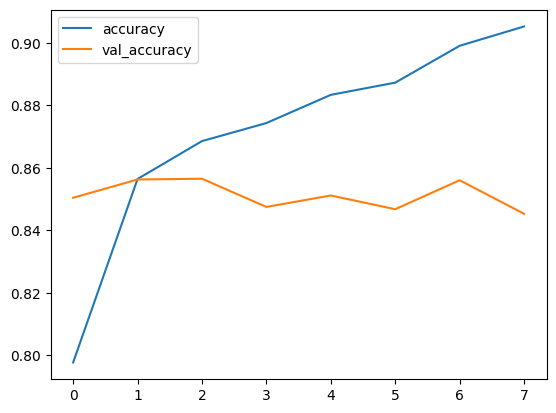

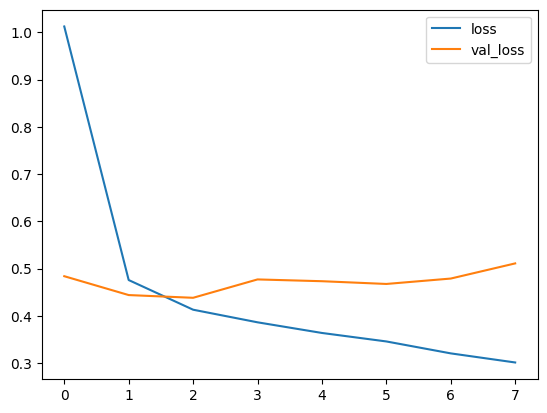

In [64]:
bi_lstm_model = tf.keras.models.Sequential([
    encoder,
    Embedding(len(encoder.get_vocabulary()), 50, mask_zero = True),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005)),
    Dropout(0.5),
    Dense(3, activation='softmax')])

bi_lstm_model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = bi_lstm_model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

In [65]:
test_loss, test_acc = bi_lstm_model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 2s 16ms/step - loss: 0.5063 - accuracy: 0.8475
Test Loss: 0.5062517523765564
Test Accuracy: 0.8475238084793091


### GloVe

In [66]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2024-01-13 20:11:22--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-01-13 20:11:23--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  3.62MB/s    in 3m 25s  

2024-01-13 20:14:49 (4.00 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [67]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [68]:
glove_path = './glove.6B.100d.txt'

embeddings_index = {}
with open(glove_path, 'r', encoding='utf8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

In [69]:
vocab = encoder.get_vocabulary()
embedding_dim = 100
embedding_matrix = np.zeros((len(vocab), embedding_dim))

for i, word in enumerate(vocab):
    if word in embeddings_index:
        embedding_matrix[i] = embeddings_index[word]
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim, ))

embedding_layer = tf.keras.layers.Embedding(
    input_dim=len(vocab),
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False
)

In [70]:
for i, word in enumerate(vocab):
  print(i)
  print(word)
  if i == 5:
    break

0

1
[UNK]
2
hotel
3
room
4
not
5
stay


#### BiLSTM model sa GloVe vektorima

Epoch 1/10
385/385 [==============================] - 18s 36ms/step - loss: 1.2098 - accuracy: 0.7501 - val_loss: 0.6767 - val_accuracy: 0.7940
Epoch 2/10
385/385 [==============================] - 13s 33ms/step - loss: 0.6387 - accuracy: 0.7935 - val_loss: 0.5470 - val_accuracy: 0.8267
Epoch 3/10
385/385 [==============================] - 13s 33ms/step - loss: 0.5648 - accuracy: 0.8212 - val_loss: 0.5489 - val_accuracy: 0.8184
Epoch 4/10
385/385 [==============================] - 18s 47ms/step - loss: 0.5330 - accuracy: 0.8248 - val_loss: 0.4906 - val_accuracy: 0.8402
Epoch 5/10
385/385 [==============================] - 18s 47ms/step - loss: 0.5021 - accuracy: 0.8345 - val_loss: 0.4721 - val_accuracy: 0.8438
Epoch 6/10
385/385 [==============================] - 19s 49ms/step - loss: 0.4896 - accuracy: 0.8370 - val_loss: 0.4646 - val_accuracy: 0.8429
Epoch 7/10
385/385 [==============================] - 19s 49ms/step - loss: 0.4618 - accuracy: 0.8446 - val_loss: 0.4523 - val_accuracy:

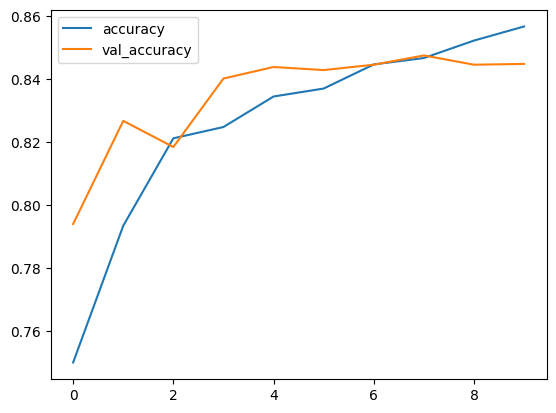

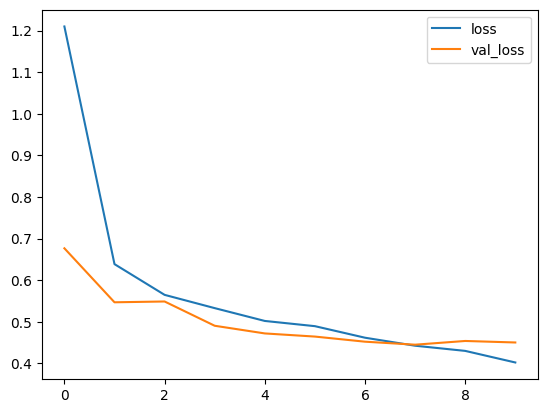

In [71]:
bi_lstm_model_glove = tf.keras.models.Sequential([
    encoder,
    embedding_layer,
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005)),
    Dropout(0.5),
    Dense(3, activation='softmax')])

bi_lstm_model_glove.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = bi_lstm_model_glove.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

In [72]:
test_loss, test_acc = bi_lstm_model_glove.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 3s 20ms/step - loss: 0.4614 - accuracy: 0.8431
Test Loss: 0.46143633127212524
Test Accuracy: 0.843132495880127


#### BiGRU model sa GloVe vektorima

In [73]:
!mkdir models

In [74]:
checkpoint_path = "models/gru_glove.ckpt"

checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                monitor="val_loss", mode="min",
                                                save_best_only=True,
                                                save_weights_only=True,
                                                verbose=1)

Epoch 1/25
385/385 [==============================] - ETA: 0s - loss: 0.6261 - accuracy: 0.7681
Epoch 1: val_loss improved from inf to 0.50862, saving model to models/gru_glove.ckpt
385/385 [==============================] - 36s 64ms/step - loss: 0.6261 - accuracy: 0.7681 - val_loss: 0.5086 - val_accuracy: 0.8075
Epoch 2/25
384/385 [============================>.] - ETA: 0s - loss: 0.4781 - accuracy: 0.8271
Epoch 2: val_loss improved from 0.50862 to 0.43051, saving model to models/gru_glove.ckpt
385/385 [==============================] - 19s 50ms/step - loss: 0.4780 - accuracy: 0.8272 - val_loss: 0.4305 - val_accuracy: 0.8392
Epoch 3/25
385/385 [==============================] - ETA: 0s - loss: 0.4271 - accuracy: 0.8441
Epoch 3: val_loss did not improve from 0.43051
385/385 [==============================] - 13s 34ms/step - loss: 0.4271 - accuracy: 0.8441 - val_loss: 0.4489 - val_accuracy: 0.8382
Epoch 4/25
384/385 [============================>.] - ETA: 0s - loss: 0.3907 - accuracy: 0

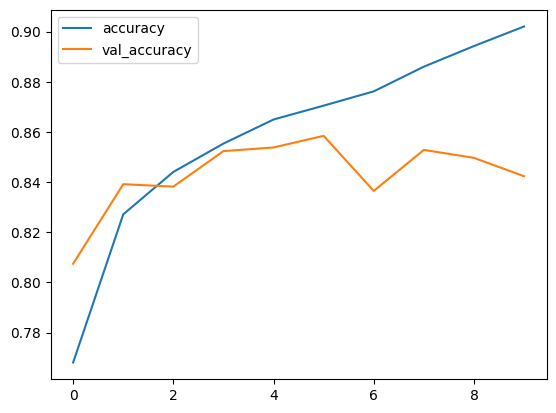

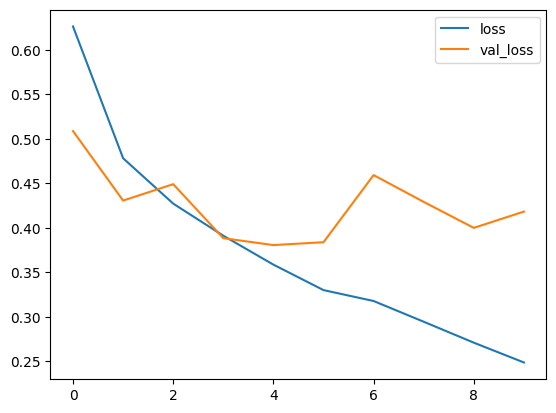

In [75]:
gru_model_glove1 = tf.keras.models.Sequential([
    encoder,
    embedding_layer,
    Bidirectional(GRU(64)),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')

gru_model_glove1.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = gru_model_glove1.fit(train_ds, epochs=25, validation_data=val_ds, callbacks=[early_stopping, checkpoint])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

#### Evaluacija modela

In [76]:
test_loss, test_acc = gru_model_glove1.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 2s 15ms/step - loss: 0.4250 - accuracy: 0.8422
Test Loss: 0.42503902316093445
Test Accuracy: 0.8421566486358643


In [77]:
y_pred = gru_model_glove1.predict(X_test)
y_pred = tf.argmax(y_pred, axis=1).numpy()

129/129 [==============================] - 3s 18ms/step


In [78]:
# Matrica konfuzije
conf_matrix = confusion_matrix(y_test, y_pred)

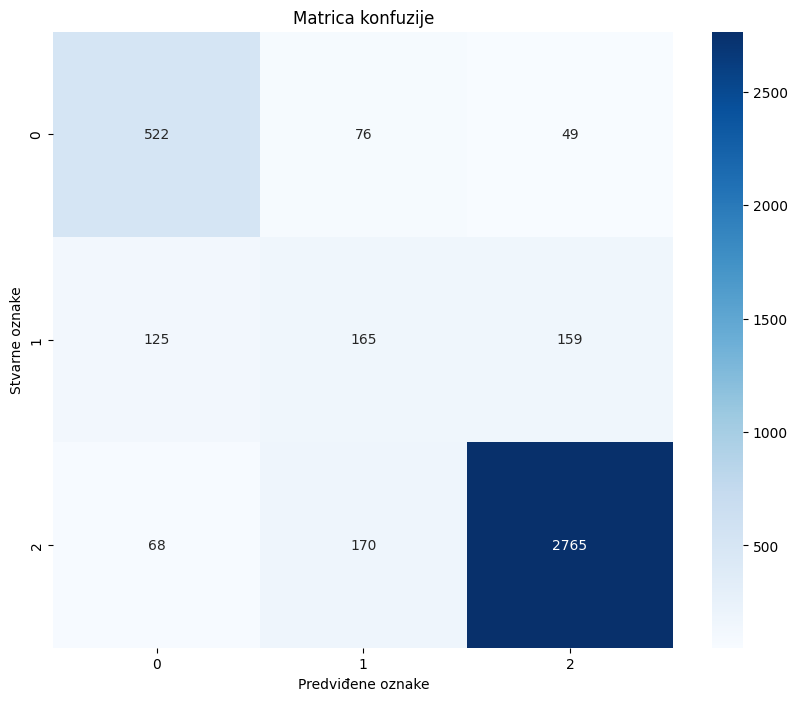

In [79]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predviđene oznake')
plt.ylabel('Stvarne oznake')
plt.title('Matrica konfuzije')
plt.show()

In [80]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose().round(2)

In [81]:
df_report

,precision,recall,f1-score,support
0,0.73,0.81,0.77,647.00
1,0.40,0.37,0.38,449.00
2,0.93,0.92,0.93,3003.00
accuracy,0.84,0.84,0.84,0.84
macro avg,0.69,0.70,0.69,4099.00
weighted avg,0.84,0.84,0.84,4099.00


### Primjer klasifikacije komentara

Sada možemo definirati model iste strukture kao `gru_model_glove1` i vratiti težine iz epohe s najboljim performansom (najmanji *loss* u ovom slučaju).

In [82]:
gru_model_glove = tf.keras.models.Sequential([
    encoder,
    embedding_layer,
    Bidirectional(GRU(64)),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')])

gru_model_glove.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [83]:
gru_model_glove.load_weights(checkpoint_path)

In [84]:
test_loss, test_acc = gru_model_glove.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 4s 19ms/step - loss: 0.3844 - accuracy: 0.8507
Test Loss: 0.38435155153274536
Test Accuracy: 0.8506953120231628


In [85]:
def classify_comment(comment, model):
    labels = ['Negative', 'Neutral', 'Positive']
    # Ručno pretprocesiranje komentara
    preprocessed_comment = custom_preprocessing_sw_removal(comment)
    # Pretvaranje u TensorFlow Dataset
    ds = tf.data.Dataset.from_tensor_slices([preprocessed_comment])
    ds = ds.batch(1)
    # Predviđanje
    prediction = model.predict(ds)
    return labels[np.argmax(prediction)]

In [86]:
comment = "I was very disappointed with my stay. The room was dirty and the service was unacceptably slow."
prediction = classify_comment(comment, gru_model_glove)
print(f"Predicted Sentiment: {prediction}\n")

1/1 [==============================] - 1s 626ms/step
Predicted Sentiment: Negative



In [87]:
# Komentari/recenzije
positive = ["This hotel exceeded all my expectations, the staff were incredibly helpful and the location was perfect.",
            "Absolutely loved my stay here! The rooms were clean, spacious, and well-equipped.",
            "Fantastic experience! The food was gourmet quality and the service was top-notch."]

negative = ["I was very disappointed with my stay. The room was dirty and the service was unacceptably slow.",
            "Terrible experience. The hotel was noisy, and the staff were rude and unhelpful.",
            "Not worth the price. The facilities were outdated and the bed was uncomfortable."]

In [88]:
for comment in positive + negative:
    print(f"Original Comment: {comment}")
    pred = classify_comment(comment, gru_model_glove)
    print(f"Predicted Sentiment: {pred}\n")
    print()

Original Comment: This hotel exceeded all my expectations, the staff were incredibly helpful and the location was perfect.
1/1 [==============================] - 0s 9ms/step
Predicted Sentiment: Positive


Original Comment: Absolutely loved my stay here! The rooms were clean, spacious, and well-equipped.
1/1 [==============================] - 0s 11ms/step
Predicted Sentiment: Positive


Original Comment: Fantastic experience! The food was gourmet quality and the service was top-notch.
1/1 [==============================] - 0s 9ms/step
Predicted Sentiment: Positive


Original Comment: I was very disappointed with my stay. The room was dirty and the service was unacceptably slow.
1/1 [==============================] - 0s 7ms/step
Predicted Sentiment: Negative


Original Comment: Terrible experience. The hotel was noisy, and the staff were rude and unhelpful.
1/1 [==============================] - 0s 8ms/step
Predicted Sentiment: Negative


Original Comment: Not worth the price. The facil